## 1. Import libraries and load the dataset 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pmd
from statsmodels.tsa.api import DynamicFactorMQ
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [60]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df['Vol.'] = df['Vol.'].str.replace('K', 'e3')
df['Vol.'] = df['Vol.'].str.replace('M', 'e6')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df

,Price,Vol.
Date,,
2017-12-01,1.0100,457320.0
2017-12-02,0.9959,970820.0
2017-12-03,0.9977,1300000.0
2017-12-04,1.0000,2910000.0
2017-12-05,1.0000,1740000.0
...,...,...
2023-06-12,1.0000,111560000.0
2023-06-13,0.9999,80350000.0
2023-06-14,0.9998,96430000.0


## 2. Split the data into training, test and validate sets

In [61]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 2)
Test shape: (303, 2)
Validate shape: (304, 2)


In [62]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1213, 2)
Test shape: (404, 2)
Validate shape: (406, 2)


In [63]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 2)
Test shape: (404, 2)
Validate shape: (203, 2)


## 3. Perform Dynamic Factor Model

### 3.1 Build and fit train data into Dynamic Factor Model

In [64]:
features = ['Price']
df_model = DynamicFactorMQ(endog=train_data, factors=2, factor_orders=1, idiosyncratic_ar1=True)
df_model_fit = df_model.fit(maxiter=100, disp=True)
df_model_fit.summary()

EM start iterations, llf=-3435.7
EM iteration 2, llf=-2034.1, convergence criterion=0.51252
EM terminated at iteration 2, llf=-2034.1, convergence criterion=0.51252 (while specified tolerance was 1e-06)


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2648: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:           ['Price', 'Vol.']   No. Observations:                 1416
Model:                Dynamic Factor Model   Log Likelihood               -2059.543
                   + 2 factors in 2 blocks   AIC                           4143.085
                     + AR(1) idiosyncratic   BIC                           4206.152
Date:                     Fri, 16 Jun 2023   HQIC                          4166.648
Time:                             15:24:55   EM Iterations                        2
Sample:                                  0                                         
                                    - 1416                                         
Covariance Type:              Not computed                                         
                          Observation equation:                           
==========================================================================
Factor loadings:          0          1    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------
           Price      -0.71      -0.50                   -0.00        0.00
            Vol.      -0.71       0.50                    0.86        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.87              0.25
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.86              0.52
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [65]:
def evaluate_dynamic_factor_model(data, start, end):
    pred = df_model_fit.predict(start=start, end=end)
    data = data[features]
    pred = pred[features]
    mse = mean_squared_error(data, pred)
    mae = mean_absolute_error(data, pred)
    mape = mean_absolute_percentage_error(data, pred)
    rmse = mean_squared_error(data, pred, squared=False)
    return pred, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [66]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_dynamic_factor_model(val_data, start=len(df)-val_size+1, end=len(df))

print("Price predict on validate data:", y_pred_val)

Price predict on validate data:          Price
1821  1.000313
1822  1.000313
1823  1.000313
1824  1.000313
1825  1.000313
...        ...
2019  1.000313
2020  1.000313
2021  1.000313
2022  1.000313
2023  1.000313

[203 rows x 1 columns]


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 3.3 Evaluate on Test data

In [67]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_dynamic_factor_model(test_data, start=train_size+1, end=train_size+test_size)
print("Price predict on test data:", y_pred_test)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Price predict on test data:          Price
1417  1.000104
1418  1.000143
1419  1.000176
1420  1.000202
1421  1.000224
...        ...
1816  1.000313
1817  1.000313
1818  1.000313
1819  1.000313
1820  1.000313

[404 rows x 1 columns]


### 3.4 Predict price for the next 30 days

In [68]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

y_next_30_days = df_model_fit.predict(start=len(df)+1, end=len(df)+30)[features]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
         Price
2024  1.000313
2025  1.000313
2026  1.000313
2027  1.000313
2028  1.000313
2029  1.000313
2030  1.000313
2031  1.000313
2032  1.000313
2033  1.000313
2034  1.000313
2035  1.000313
2036  1.000313
2037  1.000313
2038  1.000313
2039  1.000313
2040  1.000313
2041  1.000313
2042  1.000313
2043  1.000313
2044  1.000313
2045  1.000313
2046  1.000313
2047  1.000313
2048  1.000313
2049  1.000313
2050  1.000313
2051  1.000313
2052  1.000313
2053  1.000313


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.  Evaluate accuracy validate, test data

In [69]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE       MAE      MAPE      RMSE
Validate  7.999174e-07  0.000419  0.000418  0.000894
Test      3.824939e-07  0.000416  0.000417  0.000618


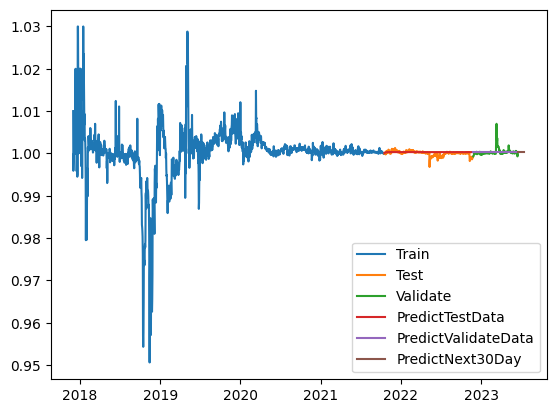

In [70]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()